In [1]:
import pickle
import os
import random
from itertools import chain

import pandas as pd
import numpy as np
import torch
from torch import nn
import tensorboardX
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
!! unzip data.zip

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [3]:
def distinct_codones(seq):
    cod_len = len(seq)
    cod_len -= cod_len % 3
    for i in range(0, cod_len, 3):
        yield seq[i:i+3]
        
def seq_codones(seq):
    return chain(*(distinct_codones(seq[i:]) for i in range(3)))

def table_codones(table):
    return chain(*(seq_codones(r[0]) for i, r in table.iterrows()))

def encode_seq(seq):
    dictionary = {}
    codes = []
    unique = 0
    for element in seq:
        if element not in dictionary:
            dictionary[element] = unique
            unique += 1
        codes.append(dictionary[element])
    return dictionary, codes

In [4]:
dictionary, codes = encode_seq(table_codones(seq_df))

In [5]:
######################

In [6]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index, center in enumerate(index_words_list):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in index_words_list[max(0, index - context): index]:
            yield center, target
        # get a random target after the center wrod
        for target in index_words_list[index + 1: index + context + 1]:
            yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def prepare_batches(codones, batch_size, skip_window):
    single_gen = generate_sample(codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [7]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = prepare_batches(codes, BATCH_SIZE, SKIP_WINDOW)

In [8]:
######################

In [9]:
class NegatigeSamplingLoss(nn.Module):
    def __init__(self, num_sample):
        super(NegatigeSamplingLoss, self).__init__()
        self.num_sample = num_sample
        
    def forward(self, out, targets, word_embedding):
        neg_indices = torch.randint(word_embedding.num_embeddings, (len(out), self.num_sample), dtype=torch.long)
        neg_samples = word_embedding(neg_indices)
        out_prods = torch.sum(out * targets, dim=1)
        neg_prods = torch.sum(out.view(out.shape[0], 1, out.shape[1]) * neg_samples, dim=2)
        out_log_sigm = torch.sigmoid(out_prods).log()
        neg_log_sgim = torch.sigmoid(neg_prods).log()
        loss = torch.sum(out_log_sigm + neg_log_sgim.sum(dim=1))
        return loss

In [10]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

In [11]:
######################

In [12]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [13]:
def train(model, batch_gen, num_train_steps, lr, name, logger, steps_before=0):
    loss_function = NegatigeSamplingLoss(5)
    optimzer = torch.optim.SGD(model.parameters(), 1e-2)
    total_loss = 0
    
    for i in range(num_train_steps):
        centers, targets = next(batch_gen)
        
        optimzer.zero_grad()
        
        out = model(centers)
        target = model(targets)
        
        target = target.squeeze()
        loss = loss_function(out, target, model)
        
        (-loss).backward()
        optimzer.step()
        
        total_loss += loss.item()
        logger.add_scalar(name + '/loss', loss.item(), i + steps_before)
        if (i + 1) % SKIP_STEP == 0:
            torch.save(model.state_dict(), name + '.pth')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
model = model.to(device)

name = 'model'
torch_batch_gen = map(lambda batch: tuple(map(lambda x: torch.LongTensor(x).to(device), batch)), batch_gen)
logger = tensorboardX.SummaryWriter(f'logs/{name}/')
train(model, torch_batch_gen, 500000, 1e-3, name, logger)
logger.add_embedding(next(model.cpu().parameters()).detach())
torch.save(model.cpu().state_dict(), f'{name}.pth')

In [11]:
######################

In [18]:
final_embed_matrix = next(model.cpu().parameters()).detach().numpy()

In [19]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [20]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0        x1 codone
0 -1.180297 -0.627515    MAF
1 -1.725006 -0.620297    SAE
2  0.716441 -0.531562    DVL
3  0.230567 -0.659048    KEY
4 -1.191029  2.478158    DRR

In [21]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

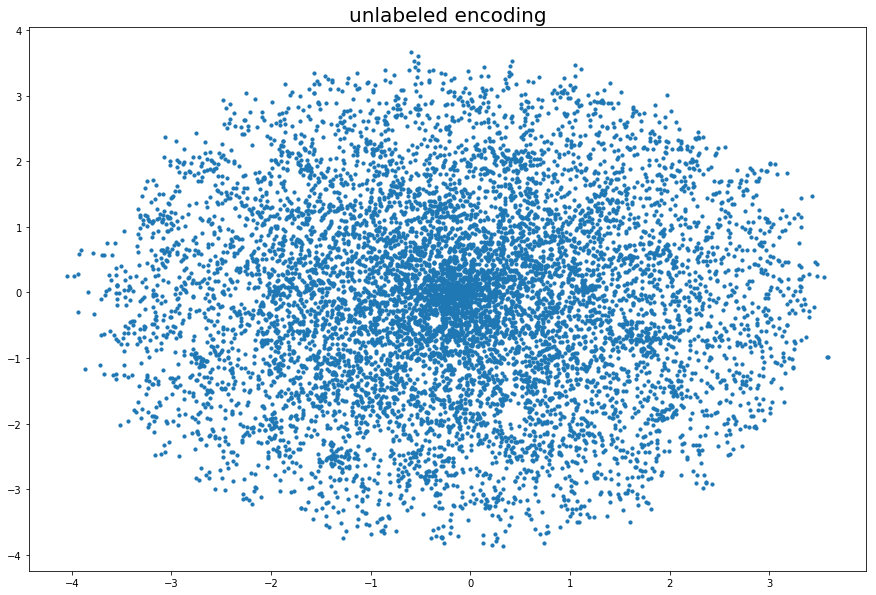

In [22]:
plot_tsne_df(tsne_df)

In [23]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [24]:
######################

In [25]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [29]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = producer()

In [30]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  MAF        2.166667  116.482633        18.666667  147.133333
1  SAE       -0.833333   95.756400        15.333333  105.333333
2  DVL        1.500000  109.125367        19.000000  139.266667
3  KEY       -2.900000  140.153200        22.333333  166.866667
4  DRR       -4.166667  142.486267        22.666667  152.633333

In [31]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume        x0  \
0  MAF        2.166667  116.482633        18.666667  147.133333 -1.180297   
1  SAE       -0.833333   95.756400        15.333333  105.333333 -1.725006   
2  DVL        1.500000  109.125367        19.000000  139.266667  0.716441   
3  KEY       -2.900000  140.153200        22.333333  166.866667  0.230567   
4  DRR       -4.166667  142.486267        22.666667  152.633333 -1.191029   

         x1  
0 -0.627515  
1 -0.620297  
2 -0.531562  
3 -0.659048  
4  2.478158

In [33]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

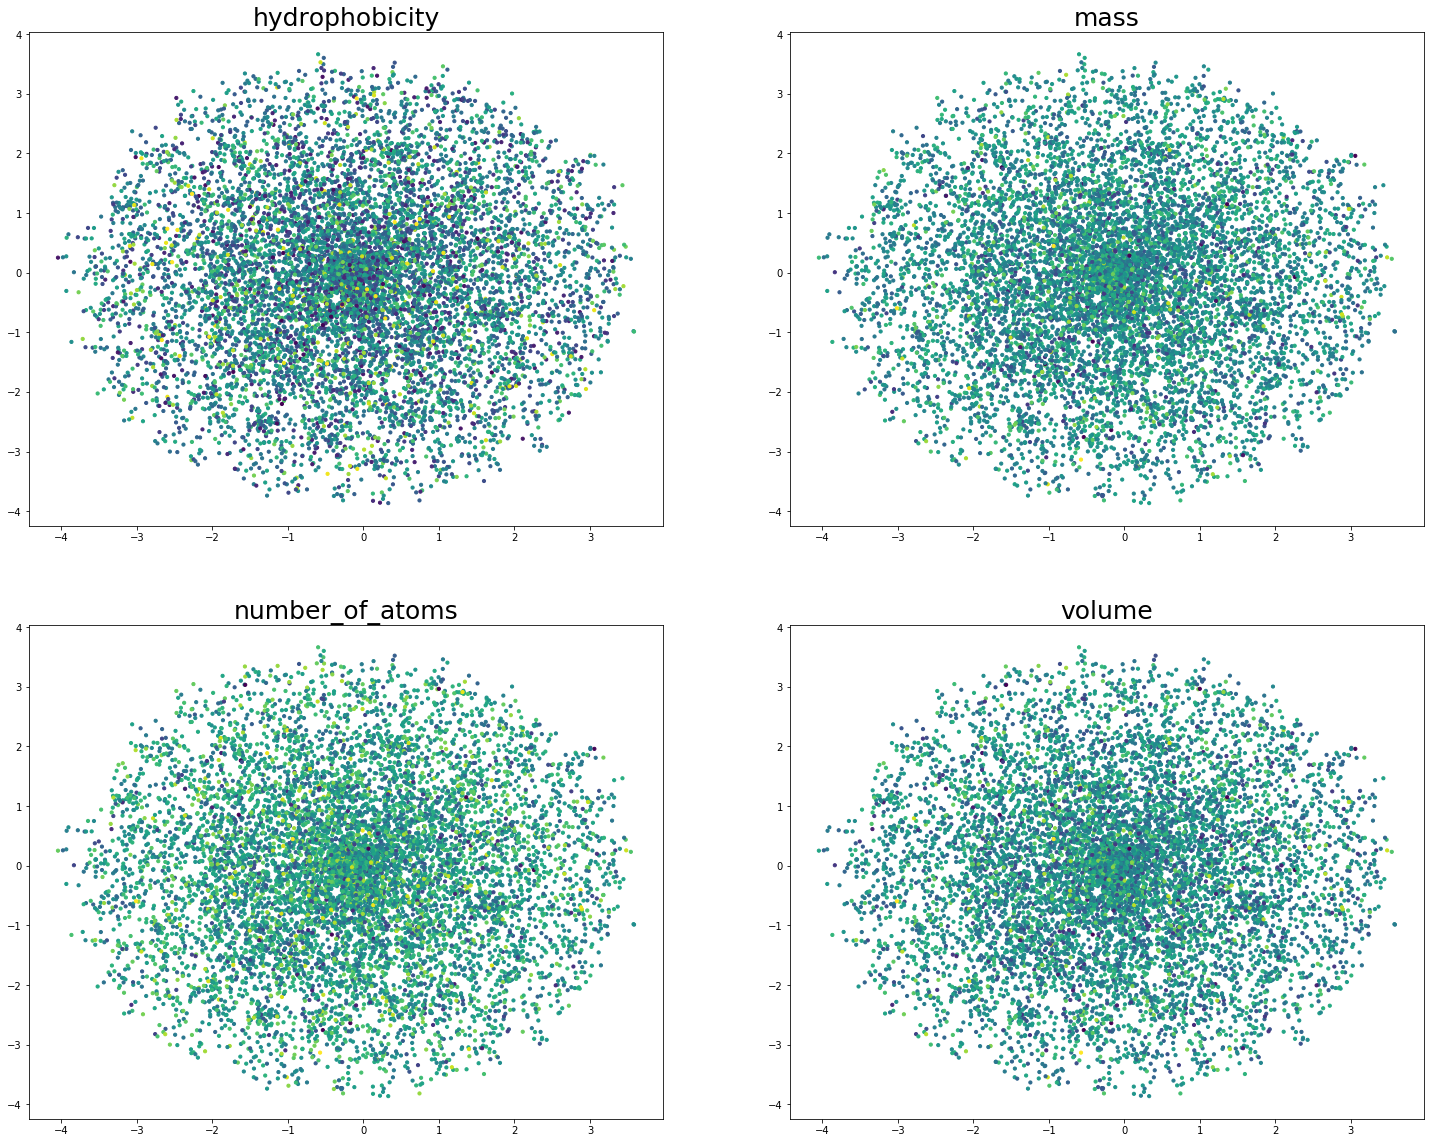

In [34]:
plot_embedding_properties(final_df)

In [28]:
######################

In [29]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

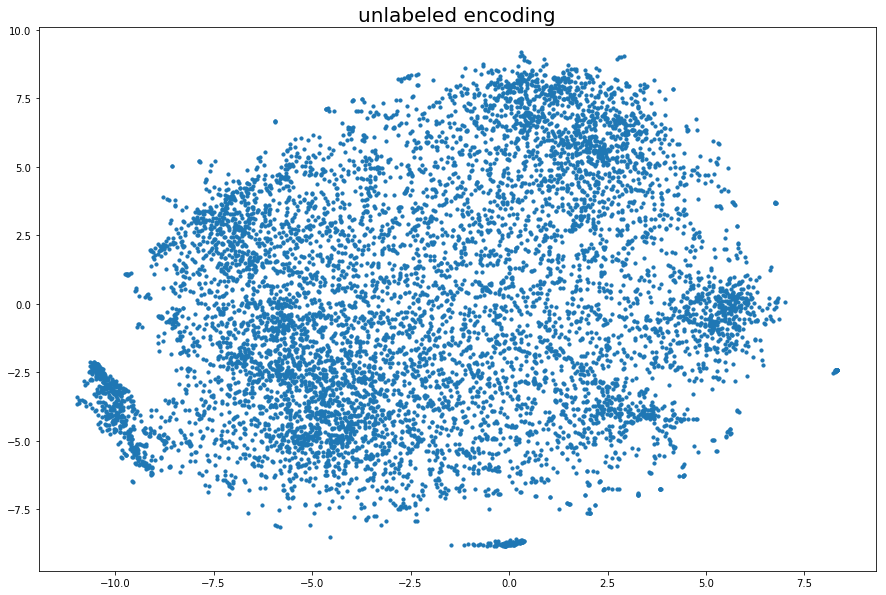

In [30]:
plot_tsne_df(gensim_tsne_df)

In [31]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

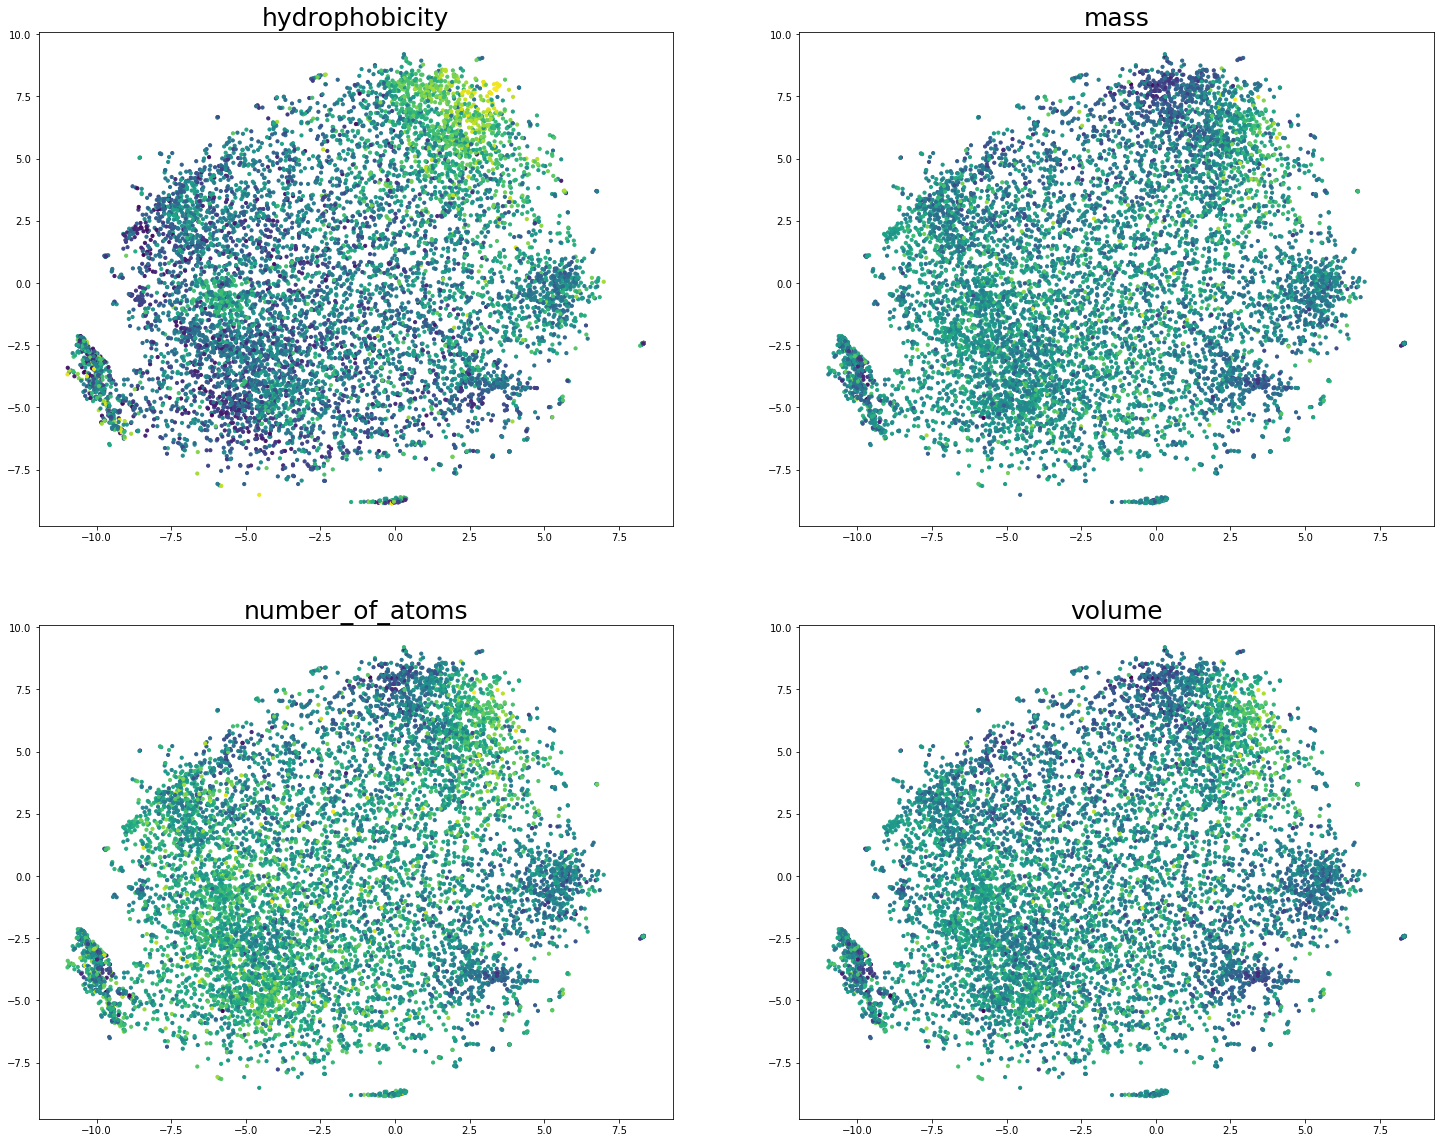

In [32]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [ ]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59